In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

Using Theano backend.


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
feats_import = pd.read_csv('All_Data_2006_2016.csv')
try:
    feats_import = feats_import.drop(['Unnamed: 0'], axis=1)
    print "Reshape successful"
except:
    print "Successful import"
feats_import.tail()

Reshape successful


,Season,Gameday,Link,TID_H,TID_A,TName_H,TName_A,FTGD,HTGD,FTHG,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_H,Interval_A,Interval_D
3199,2016,16,3201,13,3,Ein Frankfurt,Mainz,3.0,1.0,3.0,...,6.0,3.0,0.0,0.0,1.0,0.222,0.333,0.800000,0.000000,0.200000
3200,2016,16,3200,14,31,Hertha,Darmstadt,2.0,0.0,2.0,...,4.0,1.0,3.0,0.0,0.0,0.333,0.000,0.411111,0.000000,0.588889
3201,2016,16,3202,21,15,Hoffenheim,Werder Bremen,0.0,1.0,1.0,...,9.0,2.0,2.0,0.0,0.0,0.556,0.778,0.677778,0.000000,0.322222
3202,2016,16,3198,22,2,FC Koln,Leverkusen,0.0,0.0,1.0,...,5.0,0.0,0.0,0.0,0.0,0.222,0.444,0.255556,0.000000,0.744444
3203,2016,16,3203,32,23,Ingolstadt,Freiburg,-1.0,-2.0,1.0,...,3.0,4.0,2.0,0.0,0.0,0.667,0.556,0.000000,0.622222,0.377778


In [8]:
feats_import.columns

Index([u'Season', u'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H',
       u'TName_A', u'FTGD', u'HTGD', u'FTHG', u'HTHG', u'HGA', u'AGA', u'Odds',
       u'Attendance', u'ChancesA', u'ChancesH', u'HS', u'AS', u'HST', u'AST',
       u'HF', u'AF', u'HC', u'AC', u'HY', u'AY', u'HR', u'AR', u'HP3', u'AP3',
       u'Interval_H', u'Interval_A', u'Interval_D'],
      dtype='object')

In [351]:
# feats_import.loc[:, 'ChancesH'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesH'])))

In [352]:
# feats_import.loc[:, 'ChancesA'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesA'])))

In [353]:
# feats_import.loc[feats_import['Attendance']<1, 'Attendance'].plot(kind='hist', bins=40)

In [354]:
# feats_import.loc[:, 'HS'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'HS'])))

In [16]:
# Test dropping out certain features, outdated. 

# kfold = KFold(n_splits=10, shuffle=True)

# performance_list = []
# for i in range(1,21,2):
#     if i<3:
#         continue
#     np.random.seed(7)
#     X_vary = np.delete(X,(i,i+1),1)
    
#     def baseline_model():
#         model = Sequential()
#         model.add(Dense(40, input_dim=len(X_vary[0]), init='uniform', activation='relu')) 
#         # model.add(Dropout(0.3))
#         model.add(Dense(20, activation='sigmoid'))
#         model.add(Dense(80, activation='relu'))
#         model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))

#         model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         return model
#     estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=20, batch_size=20, verbose=0)
    
#     results = cross_val_score(estimator, X_vary, y, cv=kfold)
#     print feats.columns[i:i+2]
#     print [i, 100*results.mean(), 100*results.std()]
#     performance_list += [i, 100*results.mean(), 100*results.std()]


In [17]:
# Outdated

# np.random.seed(7)
# X_vary = X

# def baseline_model():
#     model = Sequential()
#     model.add(Dense(40, input_dim=len(X_vary[0]), init='lecun_uniform', activation='relu')) 
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))
#     model.add(Activation('softmax'))

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model
# estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=10, verbose=0)

# results = cross_val_score(estimator, X_vary, y)
# print 100*results.mean(), 100*results.std()

In [10]:
teams_df = pd.read_csv('Team_ID_hardcoded.csv')

In [11]:
# Goal differential Cut-off.
cutoff_GD = 3

feats = feats_import.drop(['Season', 'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H', u'TName_A', 'FTHG', 'Odds'], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

feats.columns = [u'HTGD', u'HTHG', u'HGA', u'AGA', u'Attendance', u'ChancesH', u'ChancesA', u'HS', u'AS', u'HST', u'AST',
                 u'HF', u'AF', u'HC', u'AC', u'HY', u'AY', u'HR', u'AR', u'HP3', u'AP3', u'Interval_H', u'Interval_A', u'Interval_D']

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1

# Different norms because I played around with different columns
norm = [9, 5, 1, 1, 1, 22, 22, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, 1, 1, 1]
#norm = [GD_spread-1, 9, 5, 1, 1, 1, 22, 22, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats = feats/norm

season15_end = feats_import[feats_import['Season']==2016].index[0]
ID = np.eye(GD_spread)

X = feats.iloc[:season15_end].as_matrix()
y_pre = map(int, label.iloc[:season15_end].as_matrix())

y = np.array([ID[i] for i in y_pre])



In [12]:
# Thinking about new features like conversion rate for shots etc.

conversion_df = feats_import.loc[:, ['FTGD', 'FTHG', 'HS', 'HST', 'AS', 'AST', 'HGA', 'AGA']]
conversion_df.loc[:, 'HGoals'] = conversion_df.loc[:, 'FTHG']
conversion_df.loc[:, 'AGoals'] = np.abs(conversion_df.loc[:, 'FTGD'] - conversion_df.loc[:, 'HGoals'])
conversion_df.loc[:, 'HConv'] = conversion_df.loc[:, 'HST'] / conversion_df.loc[:, 'HS']
conversion_df.loc[:, 'AConv'] = conversion_df.loc[:, 'AST'] / conversion_df.loc[:, 'AS']

conversion_df.loc[:, 'GD_color'] = (conversion_df.loc[:, 'FTGD'] - np.min(conversion_df.loc[:, 'FTGD']))

# conversion_df.plot.hexbin(x='AConv', y='AGoals', C='AGA', gridsize=30)

In [13]:
# Assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    #multiplier = np.array([-3.6, -2, -1, 0, 1, 2, 3.6])
    return np.sum(np.array(x) * multiplier)

In [17]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model = Sequential()
model.add(Dense(50, input_dim=len(X[0]), init='lecun_uniform', activation='relu')) 
model.add(Dropout(0.4))
model.add(Dense(500, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*cutoff_GD+1, activation='relu'))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, nb_epoch=100, batch_size=10, verbose=False)
print model.evaluate(X, y, batch_size=10, verbose=False)[1]

predictions = model.predict_proba(X)

0.562418307768
2784/3060 [==========================>...] - ETA: 0s

In [110]:
# Cross-Tabulation for Away-Win (-1), Draw (0) or Home-win (1)
performance_df = pd.concat([
        feats_import.iloc[:season15_end,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=feats_import.iloc[:season15_end].index)], axis=1)
success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_res_df)/season15_end,2)) + " percent"
success_res_df


Success identifying H, D, A is 84.61 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,863,57,2
0.0,156,460,138
1.0,11,107,1266


In [111]:
# Cross-Tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/season15_end,2)) + " percent"
success_df

Success identifying GD is 53.27 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,50,98,29,1,0,0,0
-2.0,2,84,186,4,0,0,0
-1.0,0,46,368,52,2,0,0
0.0,0,1,155,460,137,1,0
1.0,0,0,11,93,442,66,0
2.0,0,0,0,13,234,167,1
3.0,0,0,0,1,46,251,59


In [123]:
def points(x):
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0


    
performance_df.loc[:, "FP"] = performance_df.loc[:, "FTGD"].apply(points)
performance_df.loc[:, "EP"] = performance_df.loc[:, "EXP"].apply(points)
performance_df.loc[:, "GD_err"] = (performance_df.loc[:, "FTGD"] - performance_df.loc[:, "EXP"]).apply(np.abs)

performance_df.loc[:, "P_err"] = (performance_df.loc[:, "FP"]-performance_df.loc[:, "EP"]).apply(np.sign).apply(np.abs)

performance_df = performance_df.merge(
    performance_df.query('(GD_err == 1) & (P_err == 1)').loc[:, "P_err"].to_frame().rename(columns={"P_err":"Luck"}),
    left_index=True, right_index=True, how='left').fillna(0)

In [125]:
# Find all games that ended with an away win by one goal where the algorithm called a draw (Check invidiual games.)
# Example: Last two games all were won in last 30 minutes by away team after being behind until that point by 1 or 2 goals.
unexpected = pd.merge(
    pd.merge(
        pd.merge(
            performance_df.loc[performance_df['Luck'] == 1],
            feats_import.loc[:, ['TID_H', 'TID_A', 'Season', 'Gameday']], how='inner', left_index=True, right_index=True),
        teams_df,
        left_on='TID_H', right_on='TID').sort_values(['Season','Gameday']),
    teams_df,
    left_on='TID_A', right_on='TID', suffixes=('_H', '_A')).sort_values(['Season','Gameday']).drop(['TID_H', 'TID_A', 'KID_H', 'KID_A'], axis=1)


unexpected.loc[:, 'W'] = unexpected.loc[unexpected['FTGD']>0, 'TName_H']
unexpected.loc[:, 'L'] = unexpected.loc[unexpected['FTGD']>0, 'TName_A']

unexpected.loc[:, 'W'] = unexpected.loc[:, 'W'].fillna(unexpected.loc[:, 'TName_A'])
unexpected.loc[:, 'L'] = unexpected.loc[:, 'L'].fillna(unexpected.loc[:, 'TName_H'])

#unexpected.loc[:, 'Unexpected_GD'] = unexpected.loc[:, 'FTGD'].apply(np.abs)
unexpected.loc[:, 'Deviation'] = unexpected.loc[:, 'FTGD'].apply(np.abs) - unexpected.loc[:, 'EXP'].apply(np.abs)


lucky_punchers_df = pd.merge(feats_import.loc[:, "TName_H"].to_frame().drop_duplicates(),
                             unexpected.drop(['TName_H', 'TName_A', 'FTGD', 'EXP'], axis=1).groupby('W').count().loc[:, 'L'].to_frame(),
                             left_on="TName_H", right_index=True, how='left')
lucky_punchers_df = lucky_punchers_df.merge(unexpected.drop(['TName_H', 'TName_A', 'FTGD', 'EXP'], axis=1).groupby('L').count().loc[:, 'W'].to_frame(),
                                            left_on="TName_H", right_index=True, how='left').fillna(0.)
lucky_punchers_df.columns = ["Puncher", "W", "L"]
lucky_punchers_df.loc[:, "Diff"] = lucky_punchers_df.loc[:, "W"]-lucky_punchers_df.loc[:, "L"]
lucky_punchers_df.loc[:, "Diff_PS"] = lucky_punchers_df.loc[:, "Diff"] / np.array(np.ceil(feats_import.loc[:, ['TID_H', 'Season']].groupby('TID_H').count()/17)).flatten()

In [129]:
lucky_punchers_df.sort_values("Diff_PS", ascending=False)

,Puncher,W,L,Diff,Diff_PS
0,Bayern Munich,32.0,6.0,26.0,2.363636
2771,Ingolstadt,5.0,3.0,2.0,1.000000
1844,Greuther Furth,3.0,2.0,1.0,1.000000
1241,St Pauli,3.0,2.0,1.0,1.000000
14,Hertha,21.0,14.0,7.0,0.777778
11,Cottbus,3.0,1.0,2.0,0.666667
8,Wolfsburg,30.0,24.0,6.0,0.545455
6,Stuttgart,25.0,21.0,4.0,0.400000
2,Leverkusen,27.0,23.0,4.0,0.363636
1538,Augsburg,14.0,12.0,2.0,0.333333


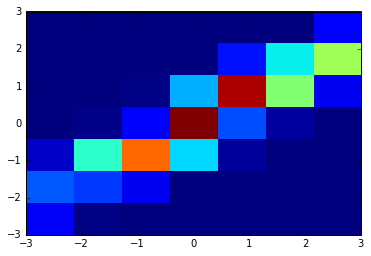

In [130]:
# Matrix Plot to visualize predictions vs. outcome

# x-axis: Actual outcome
# y-axis: Expected score (EXP)
plt_x = np.array(performance_df.loc[:, "FTGD"])
plt_y = np.array(performance_df.loc[:, "EXP"])

fig, ax = plt.subplots()

plt.hist2d(plt_x, plt_y, bins=2*cutoff_GD+1, range=np.array([(-cutoff_GD,cutoff_GD), (-cutoff_GD,cutoff_GD)]))
plt.show()

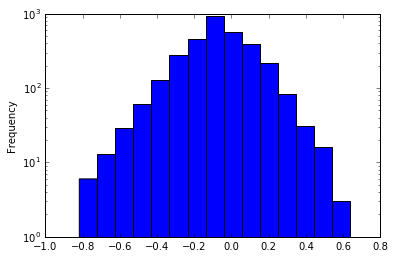

In [131]:
fig, ax = plt.subplots()
ax.set_yscale('log')
(feats.loc[:, "ChancesH"]-feats.loc[:, "ChancesA"]).plot(kind='hist', bins=15)

In [132]:
performance_df.head()

,FTGD,EXP,FP,EP,GD_err,P_err,Luck
0,2.0,2.0,3,3,0.0,0,0.0
1,0.0,-1.0,1,0,1.0,1,1.0
2,3.0,2.0,3,3,1.0,0,0.0
3,1.0,1.0,3,3,0.0,0,0.0
4,2.0,1.0,3,3,1.0,0,0.0


In [133]:
feats_noluck = feats.merge(performance_df.loc[:,"Luck"].to_frame(), 
                           left_index=True, right_index=True, 
                           how='inner').query('Luck != 1')
feats_noluck.head()

,HTGD,HTHG,HGA,AGA,Attendance,ChancesH,ChancesA,HS,AS,HST,...,HY,AY,HR,AR,HP3,AP3,Interval_H,Interval_A,Interval_D,Luck
0,0.444444,0.2,0.654545,0.654545,1.000000,0.318182,0.318182,0.333333,0.444444,0.250000,...,0.090909,0.181818,0.00,0.00,0.5,0.5,0.733333,0.000000,0.266667,0.0
2,0.555556,0.4,0.654545,0.654545,1.000000,0.000000,0.454545,0.555556,0.222222,0.305556,...,0.272727,0.000000,0.25,0.25,0.5,0.5,0.644444,0.000000,0.355556,0.0
3,0.444444,0.2,0.527273,0.527273,0.985222,0.227273,0.227273,0.305556,0.527778,0.138889,...,0.181818,0.272727,0.00,0.00,0.5,0.5,0.677778,0.000000,0.322222,0.0
4,0.333333,0.0,0.545455,0.545455,0.881092,0.272727,0.272727,0.361111,0.305556,0.222222,...,0.000000,0.363636,0.00,0.25,0.5,0.5,0.433333,0.000000,0.566667,0.0
6,0.111111,0.0,0.309091,0.309091,0.690265,0.272727,0.181818,0.277778,0.305556,0.222222,...,0.090909,0.181818,0.00,0.00,0.5,0.5,0.000000,0.588889,0.411111,0.0


In [134]:
# Define luck: Wherever our original algorithm was wrong.
# This needs to be refined obviously.
# Create df with only correctly predicted games and then learn on them
# feats.loc[:, 'luck'] = (performance_df.loc[:, 'FTGD'] - performance_df.loc[:, 'EXP']).apply(np.abs).apply(np.sign)
feats_noluck = feats.merge(performance_df.loc[:,"Luck"].to_frame(), 
                           left_index=True, right_index=True, 
                           how='inner').query('Luck != 1').drop('Luck', axis=1)

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


label_noluck = label.to_frame().merge(feats_noluck, left_index=True, right_index=True).loc[:, 'FTGD']


# ID for index to find end of 2015/16 season
ID = np.eye(GD_spread)

X_noluck = feats_noluck.ix[:season15_end].as_matrix()
y_pre_noluck = map(int, label_noluck.ix[:season15_end].as_matrix())

y_noluck = np.array([ID[i] for i in y_pre_noluck])

len(X_noluck)

2623

In [135]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for now.
model_noluck = Sequential()
model_noluck.add(Dense(50, input_dim=len(X_noluck[0]), init='lecun_uniform', activation='relu')) 
model_noluck.add(Dropout(0.4))
model_noluck.add(Dense(500, activation='relu'))
model_noluck.add(Dense(50, activation='relu'))
model_noluck.add(Dropout(0.4))
model_noluck.add(Dense(2*cutoff_GD+1, activation='relu'))
model_noluck.add(Activation('softmax'))

model_noluck.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_noluck.fit(X_noluck, y_noluck, nb_epoch=100, batch_size=10, verbose=False)
print model_noluck.evaluate(X_noluck, y_noluck, batch_size=10, verbose=False)[1]

predictions_noluck = model_noluck.predict_proba(X_noluck)

0.64696912468
2560/2623 [============================>.] - ETA: 0s

In [136]:
performance_noluck_df = pd.concat([
        (label_noluck.ix[:season15_end]-cutoff_GD).apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_noluck)), name='EXP', index=label_noluck.ix[:season15_end].index)], axis=1)
success_noluck_res_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"].apply(np.sign), performance_noluck_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_noluck_res_df)/len(label_noluck.ix[:season15_end]),2)) + " percent"
success_noluck_res_df



Success identifying H, D, A is 97.41 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,859,9,2
0.0,20,428,14
1.0,11,12,1268


In [137]:
success_noluck_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"], performance_noluck_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_noluck_df.loc[:, "EXP"].min())
exp_max = int(performance_noluck_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_noluck_df.ix[i,i] for i in range(exp_min,exp_max+1)])/len(performance_noluck_df),2)) + " percent"
success_noluck_df

Success identifying GD is 61.53 percent


EXP,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,10,156,12,0,0,0,0
-2.0,0,136,140,0,0,0,0
-1.0,0,84,321,9,2,0,0
0.0,0,0,20,428,13,1,0
1.0,0,0,10,4,361,142,2
2.0,0,0,1,7,145,254,8
3.0,0,0,0,1,15,237,104


In [138]:
X_test = feats.iloc[season15_end+1:].as_matrix()
y_test_pre = map(int, label.iloc[season15_end+1:].as_matrix())

y_test = np.array([ID[i] for i in y_test_pre])

predictions_new_season = model.predict_proba(X_test)
predictions_new_season_noluck = model_noluck.predict_proba(X_test)
print '\n'

# Measure performance without thinking about luck
performance_new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_res_df = pd.crosstab(performance_new_season_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_res_df)/len(X_test),2)) + " percent"
success_new_season_res_df

143/143 [==============================] - 0s     


Success identifying H, D, A is 79.02 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,30,6,2
0.0,4,22,11
1.0,0,7,61


### How many goals are scored more for the winning on average when the GD > cutoff

In [139]:
weights = feats_import.ix[:, 'FTGD'].value_counts(False, False, True).to_frame()
weights.loc[:, 'GD'] = weights.index
bla = weights[weights['GD']>=cutoff_GD]
print bla
print np.sum(bla.loc[:, 'FTGD']*bla.loc[:, 'GD'])/np.sum(bla.loc[:, 'FTGD'])

     FTGD   GD
3.0   224  3.0
4.0   100  4.0
5.0    32  5.0
6.0     8  6.0
7.0     6  7.0
8.0     1  8.0
3.58490566038


In [140]:
new_season_noluck_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season_noluck), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

In [141]:
pd.merge(
    new_season_df.loc[feats_import.loc[(feats_import['Season']==2016) & ((feats_import['TID_H']==5) | (feats_import['TID_A']==5))].index],
    new_season_noluck_df.loc[feats_import.loc[(feats_import['Season']==2016) & ((feats_import['TID_H']==5) | (feats_import['TID_A']==5))].index],
    left_index=True, right_index=True, suffixes=("_NL", "_L")).drop('FTGD_NL', axis=1).apply(np.round, args=(2,))

,EXP_NL,FTGD_L,EXP_L
3064,0.95,1.0,1.39
3071,0.12,-2.0,0.01
3083,1.11,2.0,1.35
3089,-0.88,-2.0,-1.12
3102,1.34,1.0,1.74
3107,2.11,3.0,2.07
3122,-0.36,0.0,-0.66
3126,1.71,3.0,1.92
3135,0.26,0.0,0.00
3144,1.09,2.0,1.50


In [142]:
comparison_df = pd.concat([new_season_df, new_season_noluck_df.loc[:, 'EXP'].rename('EXP w/o luck')], axis=1).apply(np.round, args=(2,))

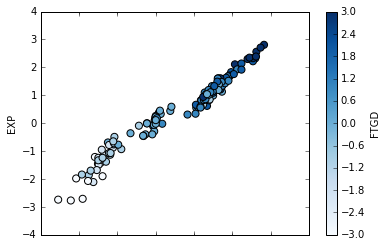

In [143]:
comparison_df.plot(kind='scatter', x='EXP w/o luck', y='EXP', c='FTGD', s=50, colormap='Blues')

In [144]:
output_df = pd.merge(new_season_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 33
# pd.merge(output_df.query('TID_A==5'), output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df

,Home_Team,Away_Team,Final,Expected
Gameday,,,,
1,Hoffenheim,RB Leipzig,0.0,0.5466
2,RB Leipzig,Dortmund,1.0,0.3671
3,Hamburg,RB Leipzig,-3.0,-1.9048
4,RB Leipzig,M'gladbach,0.0,1.0882
5,FC Koln,RB Leipzig,0.0,0.1517
6,RB Leipzig,Augsburg,1.0,1.9304
7,Wolfsburg,RB Leipzig,-1.0,-1.3809
8,RB Leipzig,Werder Bremen,2.0,0.8743
9,Darmstadt,RB Leipzig,-2.0,-1.6796


In [145]:
def rescale_grade(x):
    return 1 - (x-1.)/5
def points(x):
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0

def exp_score_cont(x):
    #multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    multiplier = np.array([0, 0, 0, 1, 3, 3, 3])
    return np.sum(np.array(x) * multiplier)

def exp_score_corr(x):
    multiplier = np.array([-3.6, -2, -1, 0, 1, 2, 3.6])
    return np.sum(np.array(x) * multiplier)

In [146]:
# Gameday 1
gd = 1

simulated_season = pd.DataFrame(data=None, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])

new_feats_df = feats.copy().loc[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)]

new_feats_df.loc[:, "TID_H"] = feats_import[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)].loc[:, "TID_H"]
new_feats_df.loc[:, "TID_A"] = feats_import[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)].loc[:, "TID_H"]

new_feats_import_df = feats_import.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)]

X_test_gameday = new_feats_df.drop([u'TID_H', u'TID_A'], axis=1).as_matrix() / norm

y_test_gameday_pre = map(int, label.iloc[season15_end+(gd-1)*9:season15_end+(gd*9)].as_matrix())
y_test_gameday = np.array([ID[i] for i in y_test_gameday_pre])

predictions_new_gameday = model_noluck.predict_proba(X_test_gameday)

data = np.array([np.array([gd for _ in range(9)]),
new_feats_import_df.loc[:, 'TID_H'].tolist(),
new_feats_import_df.loc[:, 'TID_A'].tolist(),
map(exp_score_corr, predictions_new_gameday),
map(exp_score_cont, predictions_new_gameday),
map(exp_score_cont, np.fliplr(predictions_new_gameday))]).T

simulated_df = pd.DataFrame(data=data, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])
simulated_df = pd.merge(simulated_df, new_feats_import_df.loc[:, ["Gameday", "TID_H", "FTGD"]], left_on=["Gameday", "TID_H"], right_on=["Gameday", "TID_H"])

simulated_season = simulated_season.append(simulated_df)

simulated_df.loc[:, "P_H"] = simulated_df.loc[:, "GD"].apply(np.round).apply(points)
simulated_df.loc[:, "P_A"] = (-simulated_df.loc[:, "GD"]).apply(np.round).apply(points)

simulated_df.loc[:, "H/D/A"] = simulated_df.loc[:, "GD"].apply(np.round).apply(np.sign)

simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P' + str(gd)})

standings = pd.DataFrame(pd.concat([1./3 * simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P' + str(gd)}), 
                                    1./3 * simulated_df.loc[:, ['TID_A', 'P_A']].set_index('TID_A').rename(columns={'P_A':'P' + str(gd)})])).sort_index()


last_game = pd.concat([pd.merge(new_feats_df.loc[:, ["TID_H", "HP3"]], standings.loc[:, "P" + str(gd)].to_frame(), how='inner', left_on="TID_H", right_index=True),
                       pd.merge(new_feats_df.loc[:, ["TID_A", "AP3"]], standings.loc[:, "P" + str(gd)].to_frame(), how='inner', left_on="TID_A", right_index=True)],
                      axis=1)

last_game.columns = [u'TID_H', u'HP3', u'P_H', u'TID_A', u'AP3', u'P_A']


# Gameday 2

gd = 2

new_feats_import_df = feats_import.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)]
new_feats_df = new_feats_import_df.drop(['Season', 'Gameday', u'Link', u'TName_H', u'TName_A', 'FTHG', 'Odds'], axis=1).drop('FTGD', axis=1)
new_feats_df.loc[:, 'HTGD'] = new_feats_df.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD


new_feats_df.ix[:, "HP3"] = last_game.ix[:, "P_H"].tolist()
new_feats_df.ix[:, "AP3"] = last_game.ix[:, "P_A"].tolist()



X_test_gameday = new_feats_df.drop([u'TID_H', u'TID_A'], axis=1).as_matrix() / norm

y_test_gameday_pre = map(int, label.iloc[season15_end+(gd-1)*9:season15_end+(gd*9)].as_matrix())
y_test_gameday = np.array([ID[i] for i in y_test_gameday_pre])

predictions_new_gameday = model_noluck.predict_proba(X_test_gameday)

data = np.array([np.array([gd for _ in range(9)]),
new_feats_import_df.loc[:, 'TID_H'].tolist(),
new_feats_import_df.loc[:, 'TID_A'].tolist(),
map(exp_score_corr, predictions_new_gameday),
map(exp_score_cont, predictions_new_gameday),
map(exp_score_cont, np.fliplr(predictions_new_gameday))]).T

simulated_df = pd.DataFrame(data=data, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])
simulated_df = pd.merge(simulated_df, new_feats_import_df.loc[:, ["Gameday", "TID_H", "FTGD"]], left_on=["Gameday", "TID_H"], right_on=["Gameday", "TID_H"])

simulated_season = simulated_season.append(simulated_df, ignore_index=True)
    
simulated_df.loc[:, "P_H"] = simulated_df.loc[:, "GD"].apply(np.round).apply(points)
simulated_df.loc[:, "P_A"] = (-simulated_df.loc[:, "GD"]).apply(np.round).apply(points)

simulated_df.loc[:, "H/D/A"] = simulated_df.loc[:, "GD"].apply(np.round).apply(np.sign)


standings = pd.concat(
    [standings.loc[:, "P" + str(gd-1)],
     pd.concat([1./3 * simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P'}), 
                1./3 * simulated_df.loc[:, ['TID_A', 'P_A']].set_index('TID_A').rename(columns={'P_A':'P'})]).sort_index().rename(columns={"P": "P" + str(gd)})],
    axis=1)


last_game = pd.concat([pd.merge(new_feats_df.loc[:, ["TID_H", "HP3"]], standings.loc[:, 'P' + str(gd)].to_frame(), how='inner', left_on="TID_H", right_index=True),
                       pd.merge(new_feats_df.loc[:, ["TID_A", "AP3"]], standings.loc[:, 'P' + str(gd)].to_frame(), how='inner', left_on="TID_A", right_index=True)],
                      axis=1)

last_game.columns = [u'TID_H', u'HP3', u'P_H', u'TID_A', u'AP3', u'P_A']


# Gameday 3

gd = 3
for gd in range(3,17):
    new_feats_import_df = feats_import.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)]
    new_feats_df = new_feats_import_df.drop(['Season', 'Gameday', u'Link', u'TName_H', u'TName_A', 'FTHG', 'Odds'], axis=1).drop('FTGD', axis=1)
    new_feats_df.loc[:, 'HTGD'] = new_feats_df.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

    new_feats_df.loc[:, "HP3"] = last_game.loc[:, "P_H"].tolist()
    new_feats_df.loc[:, "AP3"] = last_game.loc[:, "P_A"].tolist()


    X_test_gameday = new_feats_df.drop([u'TID_H', u'TID_A'], axis=1).as_matrix() / norm

    y_test_gameday_pre = map(int, label.iloc[season15_end+(gd-1)*9:season15_end+(gd*9)].as_matrix())
    y_test_gameday = np.array([ID[i] for i in y_test_gameday_pre])

    predictions_new_gameday = model_noluck.predict_proba(X_test_gameday)

    data = np.array([np.array([gd for _ in range(9)]),
    new_feats_import_df.loc[:, 'TID_H'].tolist(),
    new_feats_import_df.loc[:, 'TID_A'].tolist(),
    map(exp_score_corr, predictions_new_gameday),
    map(exp_score_cont, predictions_new_gameday),
    map(exp_score_cont, np.fliplr(predictions_new_gameday))]).T

    simulated_df = pd.DataFrame(data=data, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])
    simulated_df = pd.merge(simulated_df, new_feats_import_df.loc[:, ["Gameday", "TID_H", "FTGD"]], left_on=["Gameday", "TID_H"], right_on=["Gameday", "TID_H"])

    simulated_season = simulated_season.append(simulated_df, ignore_index=True)

    simulated_df.loc[:, "P_H"] = simulated_df.loc[:, "GD"].apply(np.round).apply(points)
    simulated_df.loc[:, "P_A"] = (-simulated_df.loc[:, "GD"]).apply(np.round).apply(points)

    simulated_df.loc[:, "H/D/A"] = simulated_df.loc[:, "GD"].apply(np.round).apply(np.sign)


    standings = pd.concat(
        [standings,
         pd.concat([1./3 * simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P'}), 
                    1./3 * simulated_df.loc[:, ['TID_A', 'P_A']].set_index('TID_A').rename(columns={'P_A':'P'})]).sort_index().rename(columns={"P": "P" + str(gd)})],
        axis=1)

    standings.T.rolling(3).mean().T


    last_game = pd.concat([pd.merge(new_feats_df.loc[:, ["TID_H", "HP3"]], standings.T.rolling(3).mean().T.loc[:, 'P' + str(gd)].to_frame(), how='inner', left_on="TID_H", right_index=True),
                           pd.merge(new_feats_df.loc[:, ["TID_A", "AP3"]], standings.T.rolling(3).mean().T.loc[:, 'P' + str(gd)].to_frame(), how='inner', left_on="TID_A", right_index=True)],
                          axis=1)

    last_game.columns = [u'TID_H', u'HP3', u'P_H', u'TID_A', u'AP3', u'P_A']

    new_feats_df.loc[:, "HP3"] = last_game.loc[:, "P_H"].tolist()
    new_feats_df.loc[:, "AP3"] = last_game.loc[:, "P_A"].tolist()

9/9 [==============================] - 0s


In [147]:
standings2 = pd.merge(
    simulated_season.loc[:, ["TID_H", "EP_H"]].groupby("TID_H").sum(),
    simulated_season.loc[:, ["TID_A", "EP_A"]].groupby("TID_A").sum(),
    left_index=True, right_index=True)
standings2 = standings2.loc[:, "EP_H"] + standings2.loc[:, "EP_A"]

In [148]:
simulated_season_clean = \
pd.merge(
    pd.merge(
        simulated_season, 
        teams_df, 
        left_on="TID_H", right_on="TID"),
    teams_df,
    left_on="TID_A", right_on="TID", suffixes=("_H", "_A")).loc[:, ["Gameday", "TName_H", "TName_A", "GD", "FTGD"]].sort_values("Gameday")
simulated_season_clean.loc[:, "RGD"] = simulated_season_clean.loc[:, "GD"].apply(np.round)

simulated_season_clean.head()

,Gameday,TName_H,TName_A,GD,FTGD,RGD
0,1.0,Bayern Munich,Werder Bremen,2.947565,6.0,3.0
47,1.0,M'gladbach,Leverkusen,2.529814,1.0,3.0
136,1.0,Hertha,Freiburg,2.109459,1.0,2.0
57,1.0,Augsburg,Wolfsburg,-1.175366,-2.0,-1.0
129,1.0,FC Koln,Darmstadt,2.623780,2.0,3.0


In [91]:
# plt.plot(np.array(predictions_new_gameday).T)

In [149]:
standings2016 = feats_import.loc[feats_import['Season']==2016, ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTGD']]
standings2016.loc[:, "P_H"] = standings2016.loc[:, "FTGD"].apply(points)
standings2016.loc[:, "P_A"] = (-standings2016.loc[:, "FTGD"]).apply(points)
standings2016 = pd.merge(
    standings2016.loc[:, ["TID_H", "P_H"]].groupby('TID_H').sum(),
    standings2016.loc[:, ["TID_A", "P_A"]].groupby('TID_A').sum(), left_index=True, right_index=True)
standings2016 = standings2016.loc[:, 'P_H'] + standings2016.loc[:, 'P_A']


In [154]:
standings_comparison = \
pd.concat([
        pd.concat([
            pd.merge(
                teams_df.loc[:, ['TID', 'TName']].set_index("TID"),
                3*standings.T.apply(np.sum).rename('P').to_frame(),
                left_index=True, right_index=True).sort_values("P", ascending=False),
            standings2016], axis=1),
        standings2], axis=1)
standings_comparison.columns = ["TName", "DEP", "P", "CEP"]
standings_comparison.loc[:, ["TName", "P", "DEP", "CEP"]].sort_values(["DEP", "CEP"], ascending=False).loc[:, ["TName", "P", "DEP"]].reset_index(drop=True)

,TName,P,DEP
0,Bayern Munich,39,39.0
1,RB Leipzig,36,37.0
2,Hoffenheim,28,36.0
3,Hertha,30,32.0
4,Ein Frankfurt,29,28.0
5,Freiburg,23,25.0
6,FC Koln,25,24.0
7,Dortmund,27,23.0
8,Schalke 04,18,21.0
9,M'gladbach,16,20.0


In [101]:

print '\n'

# Measure performance without thinking about luck
performance_new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_res_df = pd.crosstab(performance_new_season_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_res_df)/len(X_test),2)) + " percent"
success_new_season_res_df



Success identifying H, D, A is 79.02 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,30,6,2
0.0,4,22,11
1.0,0,7,61


In [107]:
output_df = pd.merge(new_season_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 12
# pd.merge(output_df.query('TID_A==5'),           output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df.loc[:, 'Exp. Rounded'] = np.round(schalke_df.loc[:, 'Expected'],0)
schalke_df

,Home_Team,Away_Team,Final,Expected,Exp. Rounded
Gameday,,,,,
1,Dortmund,Mainz,1.0,1.2440,1.0
2,RB Leipzig,Dortmund,1.0,0.3671,0.0
3,Dortmund,Darmstadt,3.0,2.5556,3.0
4,Wolfsburg,Dortmund,-3.0,-2.7093,-3.0
5,Dortmund,Freiburg,2.0,0.8224,1.0
6,Leverkusen,Dortmund,2.0,1.6116,2.0
7,Dortmund,Hertha,0.0,-0.6919,-1.0
8,Ingolstadt,Dortmund,0.0,0.9920,1.0
9,Dortmund,Schalke 04,0.0,0.2611,0.0


In [106]:
teams_df

,TID,KID,TName
0,0,14,Bayern Munich
1,1,12,Hamburg
2,2,9,Leverkusen
3,3,30,Mainz
4,4,15,M'gladbach
5,5,2,Schalke 04
6,6,11,Stuttgart
7,7,58,Hannover
8,8,24,Wolfsburg
9,9,81,Nurnberg
